<a href="https://colab.research.google.com/github/amitdoda1983/EVA-Session-9/blob/master/Session_9_F6_Amit_Doda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Results:
#### First of all , with cutout the validation accuracy increased from 88.9 % to 90.01 %

### Grad CAM Results
#### 1. Looking at the sample images from the validation data, it has come out very clearly in many images that there arent many important regions identified in model 1 (without cutout), however in model2 (with cutout) , every image has important regions highlighted that indicates the class being predicted.
#### 2. In many cases the region has shifted from some irrelevant position in model 1 to very obvious regions in model 2 indicating that the model is now learning what it is supposed to learn.

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
import keras.models
from keras import regularizers
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator


from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [0]:
from google.colab import drive
drive.mount('../content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ../content/drive/


In [0]:
import os
os.listdir('../content/drive/My Drive/EVA/')

['model_best.h5']

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols,img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 3s 0us/step


In [0]:
print (num_classes)
print (num_train)
print (train_features.shape)

10
50000
(50000, 32, 32, 3)


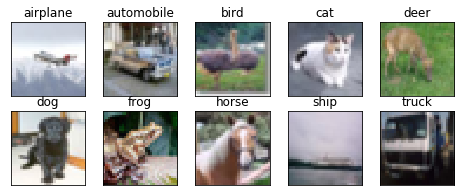

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [0]:
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()


print('Statistics train=%.3f (%.3f), test=%.3f (%.3f)' % (trainX.mean(), trainX.std(), testX.mean(), testX.std()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate the mean on the training dataset
datagen.fit(trainX)
#print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# demonstrate effect on a single batch of samples
iterator = datagen.flow(trainX, trainy, batch_size=128)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

# demonstrate effect on entire training dataset
iterator = datagen.flow(trainX, trainy, batch_size=len(trainX), shuffle=False)

# get a batch
batchX, batchy = iterator.next()

# pixel stats in the batch
print(batchX.shape, batchX.mean(), batchX.std())

Statistics train=120.708 (64.150), test=121.529 (64.061)
(128, 32, 32, 3) -0.01866643 0.97224635
(50000, 32, 32, 3) -1.6605131e-06 1.0000001


In [0]:
iterator1 = datagen.flow(testX, testy, batch_size=len(testX), shuffle=False)
batch_testX, batch_testy = iterator1.next()

X_train = batchX
X_test = batch_testX

y_train=batchy
y_test=batch_testy
                        

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [0]:
# Define the model
model1 = Sequential()
model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Convolution2D(10, 1, 1))

model1.add(AveragePooling2D(pool_size = (4,4)))
model1.add(Flatten())


model1.add(Activation('softmax'))




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same"

In [0]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='../content/drive/My Drive/EVA/model_before.h5', monitor='val_acc', mode='auto', verbose = 1, save_best_only=True)
lr_reducer = ReduceLROnPlateau(monitor='val_acc',factor=0.8, cooldown=0, patience=5, min_lr=0.5e-9,verbose = 1)



# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
__________

### Total params: 455,370

## Model 1 without Cutout

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 15s 37ms/step - loss: 1.4184 - acc: 0.5091 - val_loss: 1.1964 - val_acc: 0.5984

Epoch 00001: val_acc improved from -inf to 0.59840, saving model to ../content/drive/My Drive/EVA/model_before.h5
Epoch 2/100
390/390 [==============================] - 13s 32ms/step - loss: 0.9985 - acc: 0.6619 - val_loss: 0.9145 - val_acc: 0.6896

Epoch 00002: val_acc improved from 0.59840 to 0.68960, saving model to ../content/drive/My Drive/EVA/model_before.h5
Epoch 3/100
390/390 [==============================] - 12s 32ms/step - loss: 0.8412 - acc: 0.7242 - val_loss: 0.8031 - val_acc: 0.7359

Epoch 00003: val_acc improved from 0.68960 to 0.73590, saving model to ../content/drive/My Drive/EVA/model_before.h5
Epoch 4/100
390/390 [==============================] - 12s 32ms/step - loss: 0.7352 - acc: 0.7645 - val_loss: 0.7414 - val_acc: 0.7669

Epoch 00004: val_acc improved from 0.73590 to 0.76690, saving model to ../content/drive/My Drive/EVA/model_b

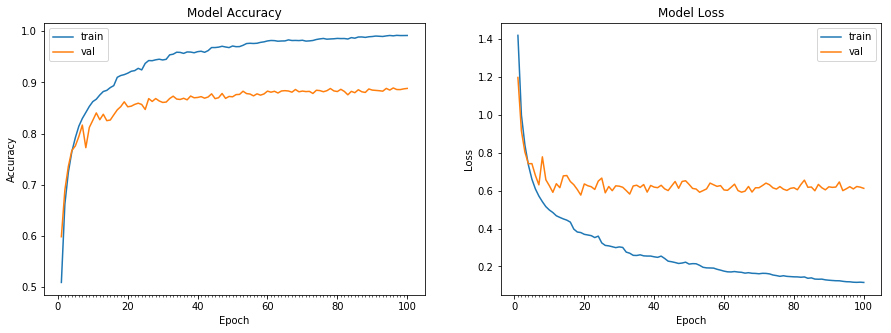

Accuracy on test data is: 88.82


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (X_test, Y_test), callbacks=[checkpointer,lr_reducer],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))

In [0]:
model=keras.models.load_model('../content/drive/My Drive/EVA/model_before.h5')


In [0]:
score = model.evaluate(X_test, Y_test, batch_size=128)
print (score[1])

10000/10000 [==============================] - 3s 299us/step
0.889


### Model 1 Grad CAM results : without Cutout

100


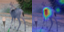

 
101


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


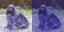

 
201


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


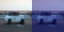

 
510


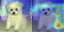

 
600


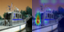

 
1000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


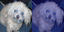

 
1600


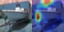

 
1601


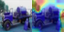

 
3000


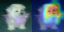

 
4000


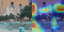

 
5500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


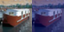

 
7000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


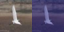

 
7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


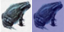

 
8000


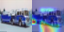

 
9000


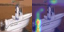

 
9999


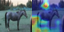

In [0]:
import cv2
from google.colab.patches import cv2_imshow

images = [100,101,201,510,600,1000,1600,1601,3000,4000,5500,7000,7500,8000,9000,9999]
for j in images:
  x = testX[j]
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x,batch_size=1)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_17")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  img = (testX[j])
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  #cv2_imshow(img)
  #cv2_imshow(superimposed_img)
  concatimg = cv2.hconcat([img,superimposed_img])
  # Display the concatenated image
  print (j)
  cv2_imshow(concatimg)
  cv2.waitKey(0)
  print (" ")
  j = j + 1


In [0]:
# Define the model
model1 = Sequential()
model1.add(Convolution2D(32, 3, 3, border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.2))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(64, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001),border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.3))

model1.add(Convolution2D(32, 1, 1))


model1.add(Convolution2D(128, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(0.0001), border_mode='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())

model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.5))

model1.add(Convolution2D(10, 1, 1))

model1.add(AveragePooling2D(pool_size = (4,4)))
model1.add(Flatten())


model1.add(Activation('softmax'))




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_regularizer=<keras.reg..., padding="same"

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_16 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [0]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

checkpointer1 = ModelCheckpoint(filepath='../content/drive/My Drive/EVA/model_after.h5', monitor='val_acc', mode='auto', verbose = 1, save_best_only=True)
lr_reducer1 = ReduceLROnPlateau(monitor='val_acc',factor=0.8, cooldown=0, patience=5, min_lr=0.5e-9,verbose = 1)



# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

## Model 2 with Cutout

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=100)`
  del sys.path[0]


Epoch 1/100
390/390 [==============================] - 18s 45ms/step - loss: 1.4672 - acc: 0.4917 - val_loss: 1.1923 - val_acc: 0.6135

Epoch 00001: val_acc improved from -inf to 0.61350, saving model to ../content/drive/My Drive/EVA/model_after.h5
Epoch 2/100
390/390 [==============================] - 13s 32ms/step - loss: 1.0810 - acc: 0.6345 - val_loss: 0.9220 - val_acc: 0.6930

Epoch 00002: val_acc improved from 0.61350 to 0.69300, saving model to ../content/drive/My Drive/EVA/model_after.h5
Epoch 3/100
390/390 [==============================] - 13s 32ms/step - loss: 0.9311 - acc: 0.6903 - val_loss: 0.8352 - val_acc: 0.7330

Epoch 00003: val_acc improved from 0.69300 to 0.73300, saving model to ../content/drive/My Drive/EVA/model_after.h5
Epoch 4/100
390/390 [==============================] - 13s 32ms/step - loss: 0.8405 - acc: 0.7246 - val_loss: 0.7646 - val_acc: 0.7593

Epoch 00004: val_acc improved from 0.73300 to 0.75930, saving model to ../content/drive/My Drive/EVA/model_afte

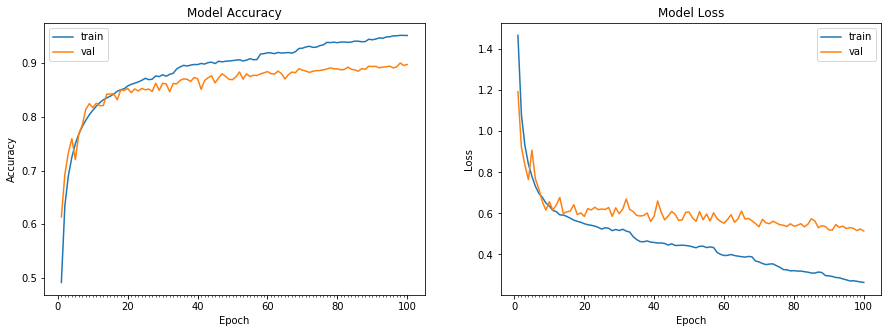

Accuracy on test data is: 89.72


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))


# train the model
start = time.time()
# Train the model
model_info = model1.fit_generator(datagen.flow(X_train, Y_train, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (X_test, Y_test), callbacks=[checkpointer1,lr_reducer1],verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(X_test, Y_test, model1))

In [0]:
model=keras.models.load_model('../content/drive/My Drive/EVA/model_after.h5')


In [0]:
score = model.evaluate(X_test, Y_test, batch_size=128)
print (score[1])

10000/10000 [==============================] - 3s 334us/step
0.9001


### Model 2 Grad CAM results : with Cutout

100


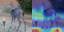

 
101


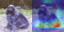

 
201


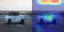

 
510


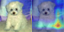

 
600


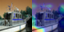

 
1000


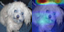

 
1600


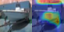

 
1601


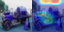

 
3000


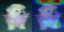

 
4000


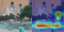

 
5500


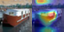

 
7000


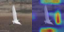

 
7500


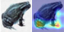

 
8000


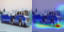

 
9000


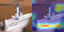

 
9999


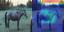

In [0]:
import cv2
from google.colab.patches import cv2_imshow

images = [100,101,201,510,600,1000,1600,1601,3000,4000,5500,7000,7500,8000,9000,9999]
for j in images:
  x = testX[j]
  x = np.expand_dims(x, axis=0)
  preds = model.predict(x,batch_size=1)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("conv2d_26")

  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(256):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap) 
  img = (testX[j])
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  #cv2_imshow(img)
  #cv2_imshow(superimposed_img)
  concatimg = cv2.hconcat([img,superimposed_img])
  # Display the concatenated image
  print (j)
  cv2_imshow(concatimg)
  cv2.waitKey(0)
  print (" ")
  j = j + 1


### Conclusions:
#### first of all , with cutout the validation accuracy increased from 88.9 % to 90.01 %
#### Looking at the sample images from the validation data, it has come out very clearly in many images that there arent many important regions identified in model 1 (without cutout), however in model2 (with cutout) , every image has important regions highlighted that indicates the class being predicted.
#### in many cases the region has shifted from some irrelevant position to very obvious regions indicating that the model is now learning what it is supposed to learn.